In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "/content/drive/MyDrive/DataforDeepLearning/brain_tumor_dataset"
SEED = 40

In [4]:
os.listdir(MAIN_DIR)

['Training', 'Testing']

In [5]:
# Inspect the raw data before preprocessing
def view_random_image():

    subdirs = ['/Training','/Testing']
    subdir = np.random.choice(subdirs)
    target_folder = MAIN_DIR + subdir

    random_image = random.sample(os.listdir(target_folder), 1)

    img = cv2.imread(target_folder+random_image[0])
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    plt.title(img.shape)
    plt.show()

In [6]:
IMG_SHAPE = (128,128)
BATCH_SIZE = 32

In [7]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.5)
train_data = datagen.flow_from_directory(MAIN_DIR,
                                        target_size=IMG_SHAPE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=True,
                                        subset="training")

test_data = datagen.flow_from_directory(MAIN_DIR,
                                       target_size=IMG_SHAPE,
                                       batch_size=BATCH_SIZE,
                                       class_mode="binary",
                                       shuffle=True,
                                       subset="validation")

Found 1632 images belonging to 2 classes.
Found 1632 images belonging to 2 classes.


In [8]:
len(train_data), len(test_data)

(51, 51)

In [9]:
tf.random.set_seed(SEED)

model = Sequential([
    Conv2D(filters=64,
           kernel_size=3,
           activation='relu'),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32,3,activation='relu'),
    Conv2D(16,3,activation='relu'),
    MaxPool2D(2, padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/10
51/51 [==============================] - 961s 19s/step - loss: 0.4078 - accuracy: 0.8646 - val_loss: 0.4423 - val_accuracy: 0.8793
Epoch 2/10
51/51 [==============================] - 11s 210ms/step - loss: 0.3445 - accuracy: 0.8799 - val_loss: 0.4278 - val_accuracy: 0.8781
Epoch 3/10
51/51 [==============================] - 11s 208ms/step - loss: 0.2998 - accuracy: 0.8842 - val_loss: 0.4191 - val_accuracy: 0.8805
Epoch 4/10
51/51 [==============================] - 10s 206ms/step - loss: 0.2635 - accuracy: 0.8891 - val_loss: 0.4472 - val_accuracy: 0.8775
Epoch 5/10
51/51 [==============================] - 11s 211ms/step - loss: 0.2254 - accuracy: 0.8977 - val_loss: 0.5002 - val_accuracy: 0.8768
Epoch 6/10
51/51 [==============================] - 10s 203ms/step - loss: 0.2074 - accuracy: 0.9020 - val_loss: 0.5191 - val_accuracy: 0.8444
Epoch 7/10
51/51 [==============================] - 10s 192ms/step - loss: 0.2000 - accuracy: 0.9044 - val_loss: 0.6620 - val_accuracy: 0.8615


In [11]:
# Function to plot loss curves
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """
    import matplotlib.pyplot as plt

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

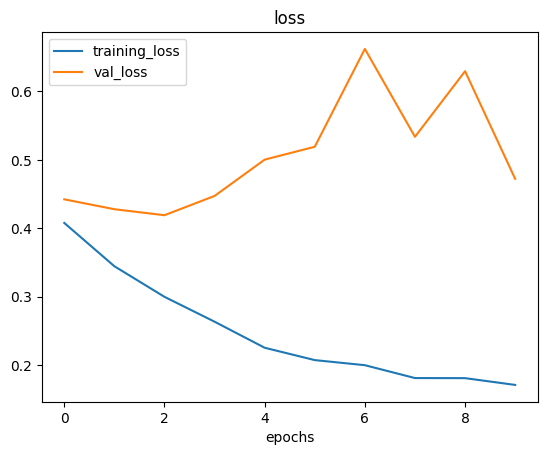

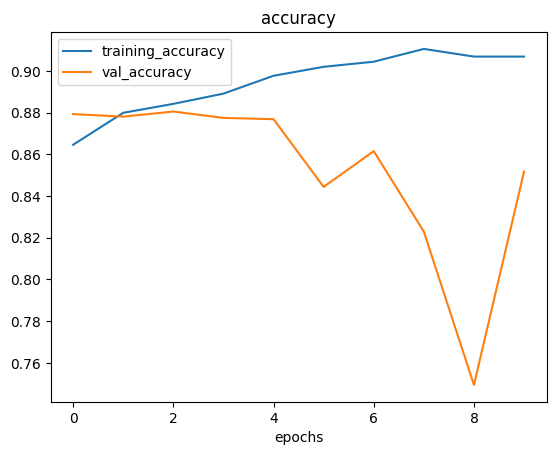

In [12]:
plot_curves(history)

In [13]:
result = model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 85.17%
Loss: 0.4722


In [14]:
# EfficientNetB0 Feature Vector
effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Feature Layer
effnet_layer = hub.KerasLayer(effnet_url,
                              trainable=False,
                              name="feature_extraction_layer")

# Create Sequential model
effnet_model = Sequential([
    effnet_layer,
    Dense(1, activation="sigmoid")
])

# Compile the model
effnet_model.compile(loss=BinaryCrossentropy(),
                     optimizer=Adam(),
                     metrics=["accuracy"])

# Fit the model
effnet_history = effnet_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/10
51/51 [==============================] - 20s 226ms/step - loss: 0.3701 - accuracy: 0.8701 - val_loss: 0.4075 - val_accuracy: 0.8744
Epoch 2/10
51/51 [==============================] - 15s 305ms/step - loss: 0.3097 - accuracy: 0.8775 - val_loss: 0.3706 - val_accuracy: 0.8768
Epoch 3/10
51/51 [==============================] - 15s 305ms/step - loss: 0.2813 - accuracy: 0.8793 - val_loss: 0.3586 - val_accuracy: 0.8781
Epoch 4/10
51/51 [==============================] - 10s 206ms/step - loss: 0.2658 - accuracy: 0.8854 - val_loss: 0.3532 - val_accuracy: 0.8768
Epoch 5/10
51/51 [==============================] - 10s 193ms/step - loss: 0.2517 - accuracy: 0.8903 - val_loss: 0.3438 - val_accuracy: 0.8787
Epoch 6/10
51/51 [==============================] - 10s 202ms/step - loss: 0.2422 - accuracy: 0.8989 - val_loss: 0.3431 - val_accuracy: 0.8781
Epoch 7/10
51/51 [==============================] - 10s 207ms/step - loss: 0.2350 - accuracy: 0.9013 - val_loss: 0.3426 - val_accuracy: 0.8775

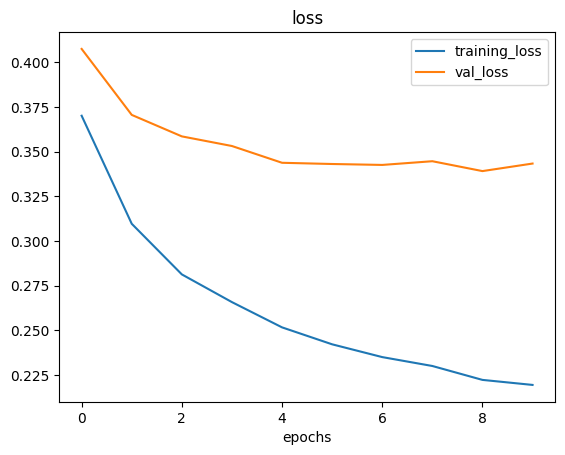

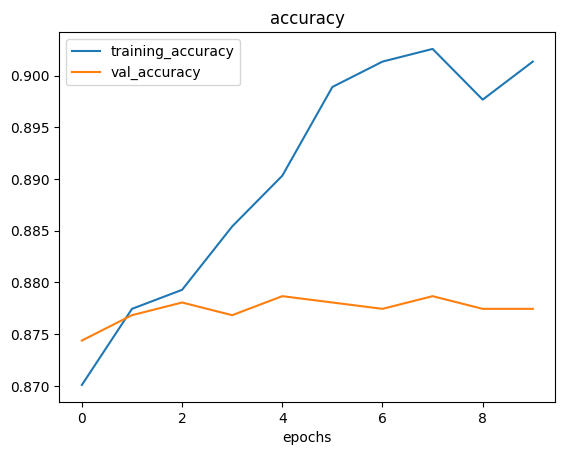

In [16]:
plot_curves(effnet_history)

In [15]:
result = effnet_model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 87.75%
Loss: 0.3434
